In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import log_loss, accuracy_score, recall_score


In [2]:
# Read dataset

data = pd.read_csv("data/data-set.csv")
print("Shape dataset:", data.shape)
data.head()

Shape dataset: (9524, 8)


subscriber     income       age      var1 gender house_type  \
0           1  118239.80  74.32310  1.216512      f      OWNER   
1           2  348760.40  45.86138  3.672188      f      OWNER   
2           3   96111.34  43.18818  0.578956      f      OWNER   
3           4   73818.17  43.32941 -0.129441      m     RENTAL   
4           5   36469.51  34.87954 -0.127675      m     RENTAL   

        lastVisit product02  
0   1/1/2012 2:09       Nee  
1  1/1/2012 14:03        Ja  
2  1/1/2012 23:58       Nee  
3   1/2/2012 3:51        Ja  
4  1/2/2012 13:50       Nee

In [3]:
# Convert date column to datetime

data["lastVisit"] = pd.to_datetime(data["lastVisit"])
data.head()

subscriber     income       age      var1 gender house_type  \
0           1  118239.80  74.32310  1.216512      f      OWNER   
1           2  348760.40  45.86138  3.672188      f      OWNER   
2           3   96111.34  43.18818  0.578956      f      OWNER   
3           4   73818.17  43.32941 -0.129441      m     RENTAL   
4           5   36469.51  34.87954 -0.127675      m     RENTAL   

            lastVisit product02  
0 2012-01-01 02:09:00       Nee  
1 2012-01-01 14:03:00        Ja  
2 2012-01-01 23:58:00       Nee  
3 2012-01-02 03:51:00        Ja  
4 2012-01-02 13:50:00       Nee

In [4]:

# Encode data (for modeling)

data["product02"] = list(map(lambda x: 0 if x == "Nee" else 1, data["product02"]))

le = preprocessing.LabelEncoder()
for column in ["gender", "house_type"]:
    le.fit(data[column])
    data[column] = le.transform(data[column])

data.head()


subscriber     income       age      var1  gender  house_type  \
0           1  118239.80  74.32310  1.216512       0           0   
1           2  348760.40  45.86138  3.672188       0           0   
2           3   96111.34  43.18818  0.578956       0           0   
3           4   73818.17  43.32941 -0.129441       1           1   
4           5   36469.51  34.87954 -0.127675       1           1   

            lastVisit  product02  
0 2012-01-01 02:09:00          0  
1 2012-01-01 14:03:00          1  
2 2012-01-01 23:58:00          0  
3 2012-01-02 03:51:00          1  
4 2012-01-02 13:50:00          0

In [5]:
# Extract features from datetime
data["lastVisitHour"] = list(map(lambda x: x.hour, data["lastVisit"]))

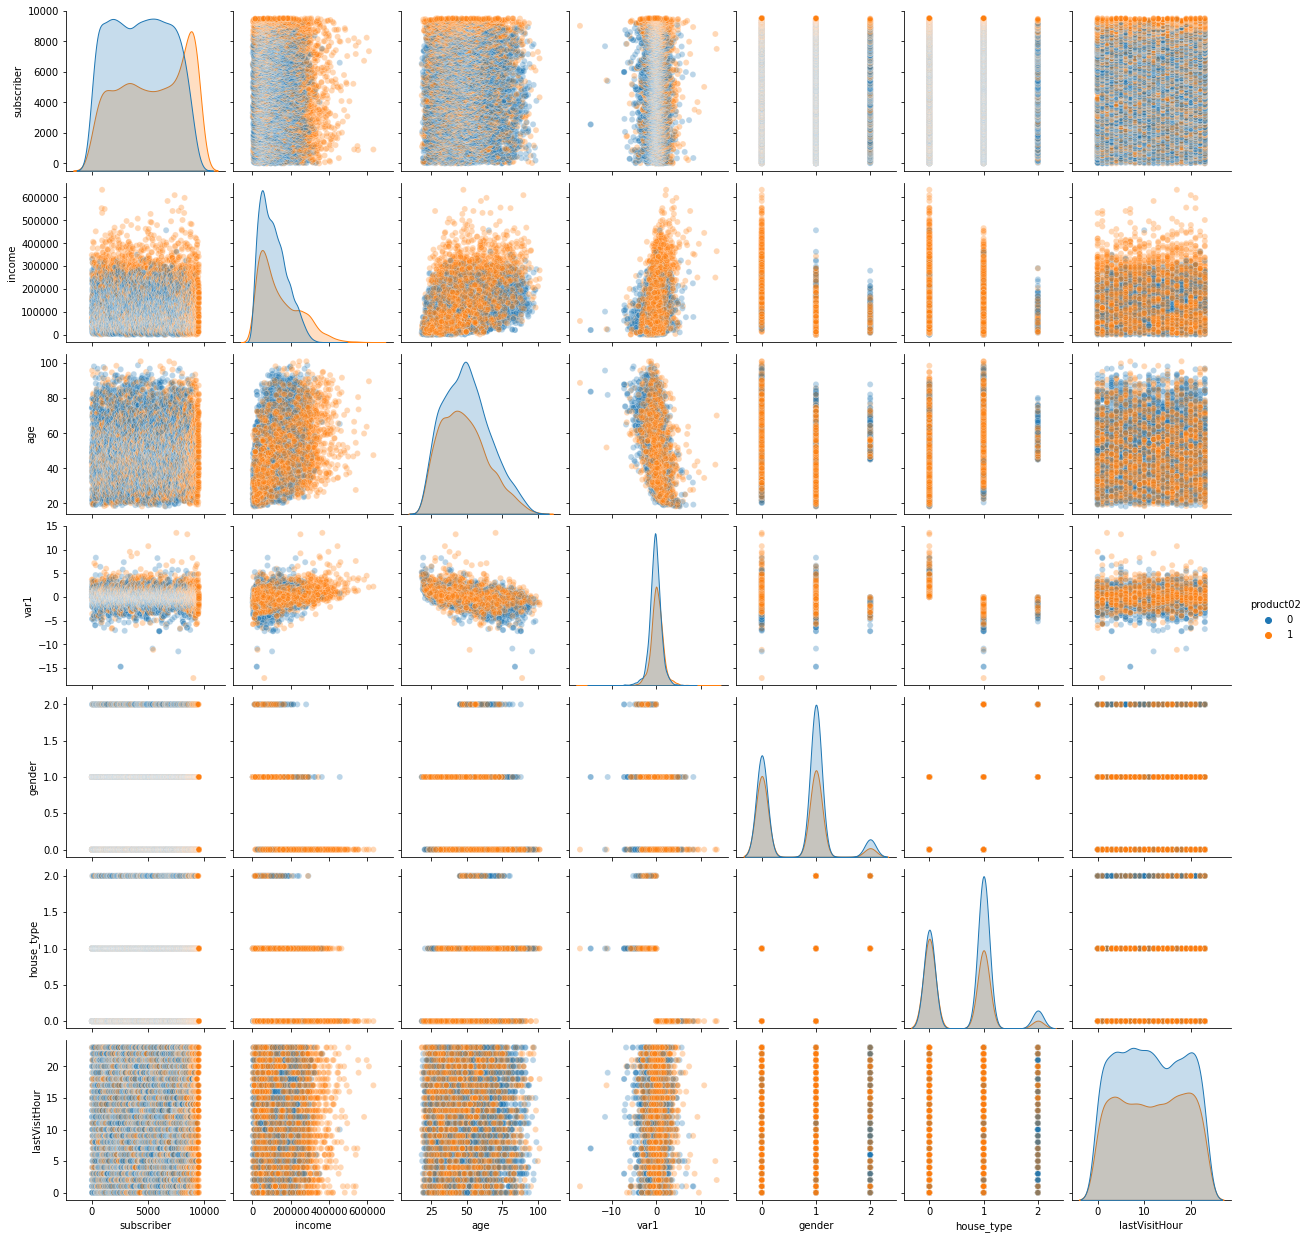

In [6]:
# Simple EDA
sns.pairplot(data, hue="product02", plot_kws=dict(alpha=0.3))

In [7]:
# Describe the dataset
data.describe()

subscriber         income          age         var1       gender  \
count  9524.000000    8966.000000  8975.000000  8952.000000  9524.000000   
mean   4762.500000  122301.927841    49.043465    -0.105003     0.649202   
std    2749.486316   89007.507823    16.288764     1.480915     0.586790   
min       1.000000     985.849800    18.209650   -17.140300     0.000000   
25%    2381.750000   52975.740000    36.247210    -0.853022     0.000000   
50%    4762.500000  101522.700000    47.870090    -0.117858     1.000000   
75%    7143.250000  170981.975000    59.644960     0.679146     1.000000   
max    9524.000000  632975.000000   101.095400    13.600780     2.000000   

        house_type    product02  lastVisitHour  
count  9524.000000  9524.000000    9524.000000  
mean      0.631247     0.410122      11.442986  
std       0.589464     0.491881       6.961544  
min       0.000000     0.000000       0.000000  
25%       0.000000     0.000000       5.000000  
50%       1.000000     0.000000      11.000000  
75%       1.000000     1.000000      18.000000  
max       2.000000     1.000000      23.000000

In [8]:
# Label distribution
count_yes = data[data["product02"] == 1].shape[0]
print("Distribution:", count_yes, " / ", data.shape[0])

Distribution: 3906  /  9524


In [9]:
# Create training dataset
X = data.copy()
del X["product02"], X["lastVisit"], X["subscriber"]
X = np.array(X.values)
X

array([[ 1.182398e+05,  7.432310e+01,  1.216512e+00,  0.000000e+00,
         0.000000e+00,  2.000000e+00],
       [ 3.487604e+05,  4.586138e+01,  3.672188e+00,  0.000000e+00,
         0.000000e+00,  1.400000e+01],
       [ 9.611134e+04,  4.318818e+01,  5.789558e-01,  0.000000e+00,
         0.000000e+00,  2.300000e+01],
       ...,
       [ 8.055836e+04,  3.710520e+01, -9.942330e-02,  0.000000e+00,
         1.000000e+00,  2.000000e+01],
       [ 1.588101e+05,  6.585983e+01, -2.633089e-01,  0.000000e+00,
         1.000000e+00,  2.200000e+01],
       [ 1.638715e+05,  4.013033e+01,  1.593538e-01,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

In [10]:
# Create training labels
y = pd.DataFrame(data["product02"].copy())
y = np.array(y.values)
y

array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [11]:
# Create simple XGB model and perform CV
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

fold = 1
logloss_scores = []
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgb_c = xgb.XGBClassifier(objective='binary:logistic',eval_metric="logloss", n_estimators=100, use_label_encoder=False)
    xgb_c.fit(X_train, y_train)
    y_pred = xgb_c.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    logloss_scores.append(score)
    print(f"[Fold {fold}]   accuracy {score:.3f}, recall {recall_score(y_test, y_pred):.3f}, logloss {log_loss(y_test, y_pred):.3f}")
    fold+=1

print(f"Mean acc {np.mean(logloss_scores):.3f}")



[Fold 1]   accuracy 0.608, recall 0.368, logloss 13.527
[Fold 2]   accuracy 0.616, recall 0.384, logloss 13.251
[Fold 3]   accuracy 0.632, recall 0.402, logloss 12.700
[Fold 4]   accuracy 0.614, recall 0.382, logloss 13.324
[Fold 5]   accuracy 0.625, recall 0.375, logloss 12.954
Mean acc 0.619


In [12]:
# Example predictions
example = xgb_c.predict(X[0:10])
example_labels = y[0:10]
print(pd.DataFrame(np.array([example, example_labels.flatten()]).T, columns=["predicted", "truth"]))


   predicted  truth
0          0      0
1          1      1
2          0      0
3          0      1
4          0      0
5          0      0
6          1      1
7          0      0
8          0      1
9          1      1


In [13]:
# Fit model and save for production use
xgb_c = xgb.XGBClassifier(objective='binary:logistic',eval_metric="logloss", n_estimators=100, use_label_encoder=False)
xgb_c.fit(X, y)
xgb_c.save_model('models/simple-model.model')